# simplerReadPlotting.ipynb
## Marcus Viscardi,    July 17, 2023

I want to quickly take some tricks I learned from fourLibrary5TERA/ambiguousReads.py and apply them here.

The goal is to be able to plot reads from a locus based on their overlap of that locus and directionality. This will be a little messier, but important for all those genes that have a had time getting reads assigned to them! (*ets-4*)

Plan is to feed this a **target_gene** and a **bam file** then use pysam to rip all the relevant reads from the bam, and plot those!

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pysam
import sys
from tqdm import tqdm
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
import nanoporePipelineCommon as npC
from finalizingReadAndCoveragePlotting_matplotlib import plot_reads, coverage_plotting_5tera

MIN_COVERAGE_OF_GENE = 50
print(f"Imports Complete @ {npC.get_dt(for_print=True)}")

Imports Complete @ 07/17/23 @ 04:25:45 PM


In [146]:
def create_cutdown_bam(target_genes: list, target_lib:str, save_dir='/tmp') -> (Path, pd.DataFrame):
    bam_file = Path(npC.pick_lib_return_path(npC.REV_CONVERSION_DICT[target_lib], output_dir_folder='cat_files', file_midfix='cat.sorted.mappedAndPrimary', file_suffix='.bam'))
    gtf_df = pd.read_parquet('/data16/marcus/genomes/'
                         'plus_cerENO2_elegansRelease100/'
                         '230327_allChrs_plus-cerENO2.gtf.parquet')
    short_gtf_df = gtf_df[(gtf_df['feature'] == 'gene') & (gtf_df['gene_name'].isin(target_genes))].copy()
    bam = pysam.AlignmentFile(bam_file, 'rb')
    cutdown_bam_path = f"{save_dir}/{npC.get_dt()}_{'_'.join(target_genes)}_{target_lib}.bam"
    cutdown_bam = pysam.AlignmentFile(cutdown_bam_path, 'wb',
                                      template=bam)
    for gene_id, gene_name in zip(short_gtf_df['gene_id'], short_gtf_df['gene_name']):
        print(f"Working on {gene_name} @ {npC.get_dt(for_print=True)}")
        chromosome, start, end, strand = \
        short_gtf_df.loc[short_gtf_df['gene_id'] == gene_id, ['chr', 'start', 'end', 'strand', ]].values[0]
        gene_is_reverse = (strand == '-')
        gene_is_forward = not gene_is_reverse
        read_iterator = tqdm(enumerate(bam.fetch(chromosome, start, end)))
        for i, read in read_iterator:
            if read.get_overlap(start, end) <= MIN_COVERAGE_OF_GENE:
                continue  # This will catch reads that are not in the gene! (50 is arbitrary)
                #           This is mainly because some reads "span" the gene, so they get fetched!
            if read.is_reverse != gene_is_reverse:
                continue  # This will catch reads that are in the wrong direction!
            read.set_tag('gA', gene_id, value_type='Z')
            read.set_tag('gN', gene_name, value_type='Z')
            read.set_tag('rS', read.reference_start, value_type='i')
            read.set_tag('rE', read.reference_end, value_type='i')
            read.set_tag('qL', read.query_length, value_type='i')
            cutdown_bam.write(read)
    for loop_bam in [cutdown_bam]:
        loop_bam.close()
        pysam.sort(loop_bam.filename, '-o', loop_bam.filename)
        pysam.index(loop_bam.filename)  # These samtools methods aren't in the pysam __init__ file, but they work!
    bam.close()
    print(f"Done. Saved to: {cutdown_bam_path}")
    return Path(cutdown_bam_path), short_gtf_df

In [147]:
target_genes = (
    'ets-4',
    'zip-1',
    'xbp-1',
)
target_lib = 'newerS6'


create_cutdown_bam(target_genes, target_lib)

Looking for file for 5tera_xrn-1-KD_smg-6_rerun, at /data16/marcus/working/230403_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on ets-4 @ 07/19/23 @ 01:31:29 PM


79it [00:00, 447.96it/s]


Working on xbp-1 @ 07/19/23 @ 01:31:29 PM


240it [00:00, 1862.50it/s]


Working on zip-1 @ 07/19/23 @ 01:31:29 PM


42it [00:00, 383.07it/s]

Done. Saved to: /tmp/230719_ets-4_zip-1_xbp-1_newerS6.bam


(PosixPath('/tmp/230719_ets-4_zip-1_xbp-1_newerS6.bam'),
         chr    source feature     start       end score strand frame gene_name         gene_id  \
 180269    X  WormBase    gene   6518883   6522656     .      +     .     ets-4  WBGene00017687   
 661454  III  WormBase    gene   4193809   4195358     .      +     .     xbp-1  WBGene00006959   
 723843  III  WormBase    gene  12333745  12345347     .      +     .     zip-1  WBGene00006986   
 
         gene_version gene_source    gene_biotype transcript_id transcript_source  \
 180269             1    WormBase  protein_coding          None              None   
 661454             1    WormBase  protein_coding          None              None   
 723843             1    WormBase  protein_coding          None              None   
 
        transcript_biotype  exon_number exon_id  
 180269               None          NaN    None  
 661454               None          NaN    None  
 723843               None          NaN    None  )

In [148]:
def bam_tag_to_df(bam_object_or_path, tags=(), chr = None, start=None, stop = None):
    if not isinstance(bam_object_or_path, pysam.AlignmentFile):
        bam = pysam.AlignmentFile(bam_object_or_path, 'rb')
    else:
        bam = bam_object_or_path
    read_names = []
    chrs = []
    chr_starts = []
    strands = []
    cigars = []
    tags_dict = {tag: [] for tag in tags}
    for read in bam.fetch(chr, start, stop):
        read_names.append(read.query_name)
        chrs.append(read.reference_name)
        chr_starts.append(read.reference_start)
        strands.append(read.is_reverse)
        cigars.append(read.cigarstring)
        for add_tag in tags:
                tags_dict[add_tag].append(read.get_tag(add_tag))
    df = pd.DataFrame({'read_id': read_names,
                       'chr_id': chrs,
                       'chr_pos': chr_starts,
                       'strand': strands,
                       'cigar': cigars,
                       **tags_dict})
    df.strand.replace({True: '-', False: '+'}, inplace=True)
    return df

In [149]:
quick_df = bam_tag_to_df(pysam.AlignmentFile(f"/tmp/{npC.get_dt()}_{'_'.join(target_genes)}_{target_lib}.bam", 'rb'), tags=['gA', 'gN', 't5', 'rS', 'rE']).rename(columns={'gA': 'gene_id', 'gN': 'gene_name'})
quick_df

,read_id,chr_id,chr_pos,strand,cigar,gene_id,gene_name,t5,rS,rE
0,26281770-91c4-4624-b3d4-9e01fcb73d81,III,4193825,+,9S22M1I29M1I29M1D17M3D32M1I6M1I3M1I47M1D25M1D1...,WBGene00006959,xbp-1,-,4193825,4195352
1,72cf64f9-956a-4318-8aae-e776bf688523,III,4193848,+,28M1I5M4D40M4D38M1I29M1D64M2I9M1D24M3D16M1I51M...,WBGene00006959,xbp-1,-,4193848,4195356
2,025d27cd-24b1-415f-bd05-896be99b4a68,III,4193894,+,11M1D19M4D6M3D2M2D13M2D7M3D56M1D32M1I78M3D16M1...,WBGene00006959,xbp-1,-,4193894,4194378
3,ba2cacdf-0ac0-4e7e-904a-be23a358583e,III,4193895,+,1S26M6D10M1D9M1I8M2D32M2D5M1D17M1D52M1D1M3D2M1...,WBGene00006959,xbp-1,-,4193895,4195352
4,707cdeee-7c82-4e64-9ed4-be764ca54fd1,III,4193896,+,3S29M4D3M3D4M2D5M1D49M1D17M1D21M1D5M1D43M1I2M1...,WBGene00006959,xbp-1,-,4193896,4195354
...,...,...,...,...,...,...,...,...,...,...
322,fd8ef15a-b8e4-4913-998c-401426c250ae,X,6522383,+,12S21M3D19M1I47M3D12M2I7M2D2M2D6M3D16M2D20M2I9...,WBGene00017687,ets-4,-,6522383,6522652
323,f95032eb-4b53-4b73-9409-5ee17efa2be7,X,6522405,+,9M1I73M1I8M2D8M3I15M1D7M3D12M2D17M3D9M1I10M1I3...,WBGene00017687,ets-4,-,6522405,6522664
324,a39c596a-e638-480a-868c-de6451b2e8ff,X,6522411,+,2S17M1I1M1I6M2D4M1D25M2D5M2D7M1D5M3D5M1I15M2D6...,WBGene00017687,ets-4,-,6522411,6522652
325,c29499a4-2c61-458e-a5d9-437099fd48cc,X,6522443,+,5M1I26M2D11M1D7M2D16M1D12M2I17M1D40M1D41M1I26M10S,WBGene00017687,ets-4,-,6522443,6522652


In [150]:
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import re
get_dt = npC.get_dt


def _make_rectangle_patch(genome_start, length, y_center, thickness, color='gray'):
    return Rectangle((genome_start, y_center - (thickness / 2)), length, thickness,
                     facecolor=color,
                     edgecolor=color,
                     fill=True,
                     lw=0)


def _add_patches_from_cigars_and_gen_pos(axes, cigar, gen_start, y, color='black', plot_introns=True):
    # Parse the cigar string
    parsed_cigar = re.findall(rf'(\d+)([MDNSIX])', cigar)
    mdn_nums = [int(num) for num, char in parsed_cigar if char in "MDN"]
    gen_end = gen_start + sum(mdn_nums)
    genomic_read_length = gen_end - gen_start

    genome_loc = gen_start

    rectangle_patch_list = []
    first_n_length = 0
    for length, code in parsed_cigar:
        length = int(length)
        if code == 'S':
            pass
        elif code == 'M':
            rectangle_patch_list.append(_make_rectangle_patch(genome_loc, length, y, thickness=0.8))
            genome_loc += length
        elif code == 'D':
            if length < 50:
                rectangle_patch_list.append(_make_rectangle_patch(genome_loc, length, y, thickness=0.8))
            else:
                if plot_introns:
                    rectangle_patch_list.append(_make_rectangle_patch(genome_loc, length, y, thickness=0.001))
            genome_loc += length
        elif code == 'I':
            pass
        elif code == 'N':
            if plot_introns:
                rectangle_patch_list.append(_make_rectangle_patch(genome_loc, length, y, thickness=0.001))
            genome_loc += length
    axes.add_collection(PatchCollection(rectangle_patch_list, color=color))
    return genomic_read_length


def _add_patches_from_cigars_and_gen_pos_gtp(axes, cigar, gen_start, y, color='black', plot_introns=True):
    # Parse the cigar string
    parsed_cigar = re.findall(rf'(\d+)([MDNSIX])', cigar)
    mdn_nums = [int(num) for num, char in parsed_cigar if char in "MDN"]
    gen_end = gen_start + sum(mdn_nums)
    genomic_read_length = gen_end - gen_start

    genome_loc = gen_start

    rectangle_patch_list = []
    current_length = 0
    for length, code in parsed_cigar:
        length = int(length)
        if code == 'S':
            pass
        elif code == 'M':
            current_length += length
            genome_loc += length
        elif code == 'D':
            current_length += length
            genome_loc += length
        elif code == 'I':
            pass
        elif code == 'N':
            if plot_introns:
                # Only add the accumulated length as a single rectangle if we encountered matches or deletes
                if current_length > 0:
                    rectangle_patch_list.append(_make_rectangle_patch(genome_loc - current_length, current_length, y, thickness=0.8))
                    current_length = 0
                rectangle_patch_list.append(_make_rectangle_patch(genome_loc, length, y, thickness=0.001))
            genome_loc += length

    # Add the accumulated length as a single rectangle if we reached the end of the cigar
    if current_length > 0:
        rectangle_patch_list.append(_make_rectangle_patch(genome_loc - current_length, current_length, y, thickness=0.8))

    axes.add_collection(PatchCollection(rectangle_patch_list, color=color))

    return genomic_read_length


def _row_apply_plot_cigar(row, axes, plot_introns=True):
    index = row.name
    cigar = row.cigar
    gen_start = row.ref_start
    is_adapted = row.t5

    if is_adapted == '-':
        color = 'black'
    else:
        color = 'red'
    return _add_patches_from_cigars_and_gen_pos_gtp(axes, cigar, gen_start, index,
                                                    color=color,
                                                    plot_introns=plot_introns)

def new_plot_reads_from_bam(target_lib_nickname,
                            target_gene_name,
                            save_dir=None,
                            ):
    # First lets make the tmp BAM file that only has the gene of interest:
    tmp_bam_path, short_gtf_df = create_cutdown_bam([target_gene_name], target_lib_nickname)
    bam_df = bam_tag_to_df(tmp_bam_path, tags=['gA', 'gN', 't5', 'rS', 'rE', 'qL'])
    bam_df.rename(columns={'gA': 'gene_name',
                           'gN': 'gene_id',
                           't5': 't5',
                           'rS': 'ref_start',
                           'rE': 'ref_end',
                           'qL': 'read_length'},
                  inplace=True)
    read_count = bam_df.shape[0]
    print(f"{read_count:>6,} reads in {target_lib_nickname} that match {target_gene_name}")
    
    # Get some gene info:
    gene_id, chromosome, genomic_start, genomic_end, gene_strand = short_gtf_df.loc[short_gtf_df['gene_name'] == target_gene_name, ['gene_id', 'chr', 'start', 'end', 'strand']].values[0]
    
    # Now lets plot the reads:
    fig, ax = plt.subplots(figsize=(5, (read_count * 0.05)))
    
    if gene_strand == "-":
        sort_order = ["t5", "ref_end", "ref_start", "read_length"]
        sort_order_ascending = [False, True, False, False]
    else:  # gene_strand == "+":
        sort_order = ["t5", "ref_start", "ref_end", "read_length"]
        sort_order_ascending = [False, False, False, False]
    tqdm.pandas(desc="Plotting Reads...")
    bam_df = bam_df.sort_values(sort_order, ascending=sort_order_ascending).reset_index(drop=True)
    
    tqdm.pandas(desc="Plotting Reads...")
    bam_df.progress_apply(lambda row: _row_apply_plot_cigar(row, ax), axis=1)

    ax.set_xlim(genomic_start, genomic_end)
    
    number_of_plotted_reads = bam_df.shape[0]
    ax.set_ylim(-1, number_of_plotted_reads + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    if save_dir is not None:
        save_path = f"{save_dir}/{get_dt()}_{target_lib_nickname}_{target_gene_name}.readPlotting"
        for suffix in ["png", "svg"]:
            plt.savefig(f"{save_path}.{suffix}", dpi=300)
        print(f"Saved images to: {save_path}.png/svg")
    plt.show()
    return bam_df

Looking for file for 5tera_xrn-1-KD_wt_rerun, at /data16/marcus/working/230327_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on ets-4 @ 07/19/23 @ 01:31:42 PM


45it [00:00, 30354.40it/s]


Done. Saved to: /tmp/230719_ets-4_newerN2.bam
    36 reads in newerN2 that match ets-4


Plotting Reads...: 100%|██████████| 36/36 [00:00<00:00, 1969.23it/s]

Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/ets-4/230719_newerN2_ets-4.readPlotting.png/svg


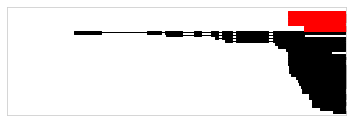

Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on ets-4 @ 07/19/23 @ 01:31:42 PM


41it [00:00, 494.66it/s]


Done. Saved to: /tmp/230719_ets-4_oldN2.bam
    30 reads in oldN2 that match ets-4


Plotting Reads...: 100%|██████████| 30/30 [00:00<00:00, 2206.83it/s]


Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/ets-4/230719_oldN2_ets-4.readPlotting.png/svg


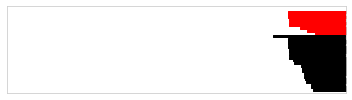

Looking for file for 5tera_xrn-1-KD_smg-6_rerun, at /data16/marcus/working/230403_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on ets-4 @ 07/19/23 @ 01:31:43 PM


79it [00:00, 16821.51it/s]


Done. Saved to: /tmp/230719_ets-4_newerS6.bam
    69 reads in newerS6 that match ets-4


Plotting Reads...: 100%|██████████| 69/69 [00:00<00:00, 1750.10it/s]


Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/ets-4/230719_newerS6_ets-4.readPlotting.png/svg


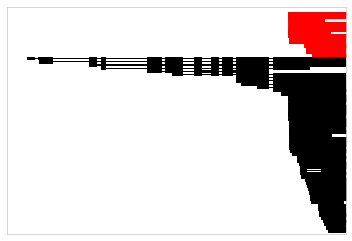

Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on ets-4 @ 07/19/23 @ 01:31:44 PM


17it [00:00, 175.32it/s]


Done. Saved to: /tmp/230719_ets-4_oldS6.bam
    11 reads in oldS6 that match ets-4


Plotting Reads...: 100%|██████████| 11/11 [00:00<00:00, 137.98it/s]

Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/ets-4/230719_oldS6_ets-4.readPlotting.png/svg


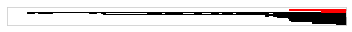

Looking for file for 5tera_xrn-1-KD_smg-5_rerun, at /data16/marcus/working/230410_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on ets-4 @ 07/19/23 @ 01:31:45 PM


52it [00:00, 1276.49it/s]


Done. Saved to: /tmp/230719_ets-4_newerS5.bam
    43 reads in newerS5 that match ets-4


Plotting Reads...: 100%|██████████| 43/43 [00:00<00:00, 1845.14it/s]

Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/ets-4/230719_newerS5_ets-4.readPlotting.png/svg


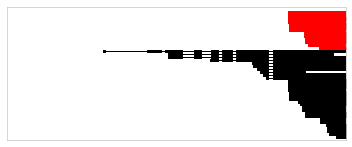

Looking for file for 5tera_xrn-1-KD_wt_rerun, at /data16/marcus/working/230327_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on xbp-1 @ 07/19/23 @ 01:31:45 PM


106it [00:00, 695.91it/s]

Done. Saved to: /tmp/230719_xbp-1_newerN2.bam
   105 reads in newerN2 that match xbp-1



Plotting Reads...: 100%|██████████| 105/105 [00:00<00:00, 1607.41it/s]


Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/xbp-1/230719_newerN2_xbp-1.readPlotting.png/svg


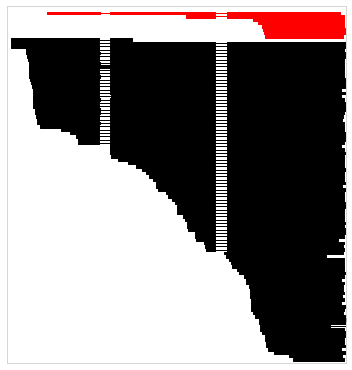

Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on xbp-1 @ 07/19/23 @ 01:31:46 PM


117it [00:00, 1255.23it/s]


Done. Saved to: /tmp/230719_xbp-1_oldN2.bam
   117 reads in oldN2 that match xbp-1


Plotting Reads...: 100%|██████████| 117/117 [00:00<00:00, 1553.49it/s]


Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/xbp-1/230719_oldN2_xbp-1.readPlotting.png/svg


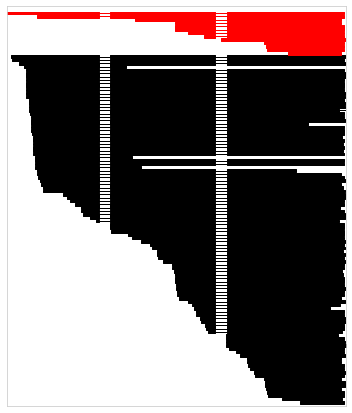

Looking for file for 5tera_xrn-1-KD_smg-6_rerun, at /data16/marcus/working/230403_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on xbp-1 @ 07/19/23 @ 01:31:46 PM


240it [00:00, 13604.07it/s]


Done. Saved to: /tmp/230719_xbp-1_newerS6.bam
   240 reads in newerS6 that match xbp-1


Plotting Reads...: 100%|██████████| 240/240 [00:00<00:00, 1681.59it/s]


Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/xbp-1/230719_newerS6_xbp-1.readPlotting.png/svg


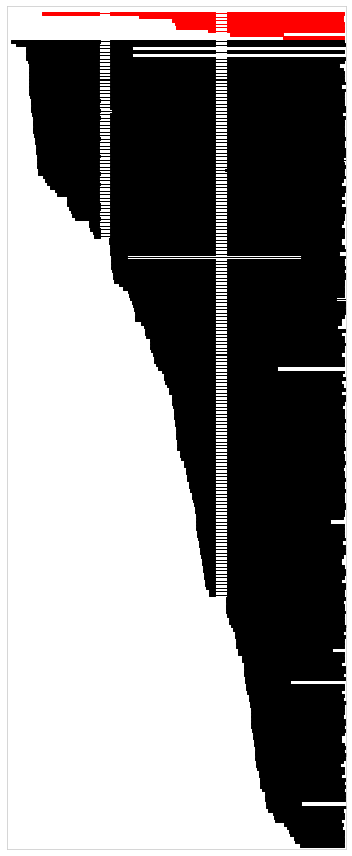

Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on xbp-1 @ 07/19/23 @ 01:31:47 PM


26it [00:00, 1305.49it/s]


Done. Saved to: /tmp/230719_xbp-1_oldS6.bam
    26 reads in oldS6 that match xbp-1


Plotting Reads...: 100%|██████████| 26/26 [00:00<00:00, 1492.19it/s]

Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/xbp-1/230719_oldS6_xbp-1.readPlotting.png/svg


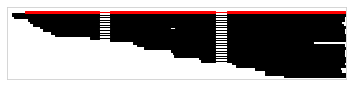

Looking for file for 5tera_xrn-1-KD_smg-5_rerun, at /data16/marcus/working/230410_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on xbp-1 @ 07/19/23 @ 01:31:48 PM


133it [00:00, 706.20it/s]


Done. Saved to: /tmp/230719_xbp-1_newerS5.bam
   132 reads in newerS5 that match xbp-1


Plotting Reads...: 100%|██████████| 132/132 [00:00<00:00, 1705.16it/s]


Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/xbp-1/230719_newerS5_xbp-1.readPlotting.png/svg


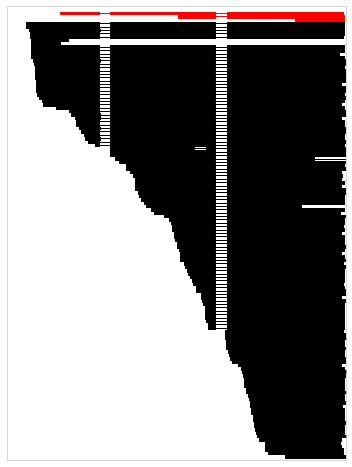

Looking for file for 5tera_xrn-1-KD_wt_rerun, at /data16/marcus/working/230327_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on zip-1 @ 07/19/23 @ 01:31:48 PM


36it [00:00, 452.00it/s]


Done. Saved to: /tmp/230719_zip-1_newerN2.bam
     7 reads in newerN2 that match zip-1


Plotting Reads...: 100%|██████████| 7/7 [00:00<00:00, 1803.89it/s]

Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/zip-1/230719_newerN2_zip-1.readPlotting.png/svg


Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on zip-1 @ 07/19/23 @ 01:31:49 PM


39it [00:00, 1604.68it/s]


Done. Saved to: /tmp/230719_zip-1_oldN2.bam
     7 reads in oldN2 that match zip-1


Plotting Reads...: 100%|██████████| 7/7 [00:00<00:00, 1319.14it/s]

Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/zip-1/230719_oldN2_zip-1.readPlotting.png/svg


Looking for file for 5tera_xrn-1-KD_smg-6_rerun, at /data16/marcus/working/230403_nanoporeRun_totalRNA_smg-6_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on zip-1 @ 07/19/23 @ 01:31:49 PM


42it [00:00, 23224.89it/s]


Done. Saved to: /tmp/230719_zip-1_newerS6.bam
    18 reads in newerS6 that match zip-1


Plotting Reads...: 100%|██████████| 18/18 [00:00<00:00, 1147.73it/s]

Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/zip-1/230719_newerS6_zip-1.readPlotting.png/svg


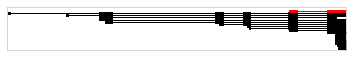

Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on zip-1 @ 07/19/23 @ 01:31:50 PM


5it [00:00, 180.82it/s]


Done. Saved to: /tmp/230719_zip-1_oldS6.bam
     3 reads in oldS6 that match zip-1


Plotting Reads...: 100%|██████████| 3/3 [00:00<00:00, 1467.22it/s]

Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/zip-1/230719_oldS6_zip-1.readPlotting.png/svg



/tmp/ipykernel_47889/2519762848.py:147: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Looking for file for 5tera_xrn-1-KD_smg-5_rerun, at /data16/marcus/working/230410_nanoporeRun_totalRNA_smg-5_xrn-1-KD_5TERA_rerun/output_dir/cat_files/*cat.sorted.mappedAndPrimary.bam... File Found.
Working on zip-1 @ 07/19/23 @ 01:31:50 PM


19it [00:00, 310.00it/s]


Done. Saved to: /tmp/230719_zip-1_newerS5.bam
     9 reads in newerS5 that match zip-1


Plotting Reads...: 100%|██████████| 9/9 [00:00<00:00, 1401.37it/s]

Saved images to: /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230719_readPlots/zip-1/230719_newerS5_zip-1.readPlotting.png/svg


In [151]:

sup_save_dir = f"/home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/{get_dt()}_readPlots"
for gene in ["ets-4",
             "xbp-1",
             "zip-1",
             ]:
    save_dir = f"{sup_save_dir}/{gene}"
    Path(save_dir).mkdir(exist_ok=True, parents=True)
    for lib in ["newerN2",
                "oldN2",
                "newerS6",
                "oldS6",
                "newerS5",
                ]:
        new_plot_reads_from_bam(lib, gene, save_dir=save_dir)